# FPUT system

Author: Martin Horvat, July 2023

Ref:

  * The Metastable State of Fermi–Pasta–Ulam–Tsingou Models 
  https://www.mdpi.com/1099-4300/25/2/300#B13-entropy-25-00300
  * The Fermi—Pasta—Ulam Problem and the Metastability Perspective
  https://www.researchgate.net/publication/225587332_The_Fermi-Pasta-Ulam_Problem_and_the_Metastability_Perspective

In [1]:
import numpy as np
import pylab as plt

from scipy.integrate import solve_ivp

In [2]:
"""
  Essential functions of FPUT model
"""

# potential
fun_V = lambda x, alpha, beta: x**2/2 + alpha*x**3/3 + beta*x**4/4

# derivative of potential
fun_dV = lambda x, alpha, beta: x + alpha*x**2 + beta*x**3

# Hamilton function
#  H = 1/2 sum_{i=0}^{n-1} p_i^2 + sum_{i=0}^n V(x_i - x_{i-1})
# with x_-1 = x_n = 0
def fun_H(s, alpha, beta):
    
    x, p = np.array_split(s, 2)
    
    # [x[0], x[1]-x[0], x[2]-x[1], ..., x[n-1]-x[n-2],-x[n-1]] 
    t = np.append(x,0) - np.insert(x,0,0)

    return (p**2/2).sum() + fun_V(t, alpha, beta).sum()

# Force: F = -dV/dx
def fun_F(x, alpha, beta):
    
    # 0, x[0], ..., x[n-1], 0
    t = np.append(np.insert(x, 0, 0),0)
    
    n = len(x)
    
    f = lambda x : fun_dV(x, alpha, beta)
    
    return np.array([f(t[i+1] - t[i]) - f(t[i] - t[i-1]) for i in range(1, n+1)])

# Time derivative of state vector
def fun_Dstate(t, s, alpha, beta):
    
    x, p = np.array_split(s, 2)
    
    return np.concatenate((p, fun_F(x, alpha, beta)))

In [3]:
# Finding FPUT trajectory

seed = 42
rng = np.random.default_rng(seed)

# initial state
d = 8
s0 = rng.normal(0, 1, size = 2*d)

# times
t_span = (0,1000)
ts = np.arange(t_span[0], t_span[1], 0.1)

# parameter
pars = (0.5, 0.1)

# solution
sol = solve_ivp(fun_Dstate, t_span, s0, t_eval = ts, args = pars, rtol=1e-8, atol=1e-8, max_step=0.01, method="Radau")

In [4]:
qs = sol.y[:d].T
ps = sol.y[d:].T

In [5]:
folder_path = r"D:\\School\\Magistrska\\data"

np.save(folder_path+r"\data_qs_3.npy", qs)
np.save(folder_path+r"\data_ps_3.npy", ps)

(10000,)
init H: 9.55090698620534  init H/N: 1.1938633732756676


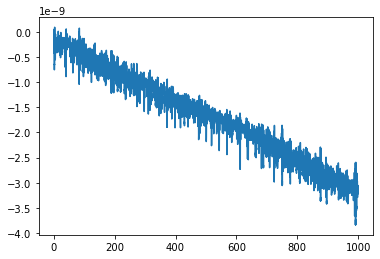

In [6]:
# checking energy conservation
e = np.apply_along_axis(lambda x: fun_H(x, *pars), 0, sol.y)
print(e.shape)
print("init H:", e[0], " init H/N:", e[0]/d)
plt.plot(ts, (e - e[0])/e[0])
plt.show()

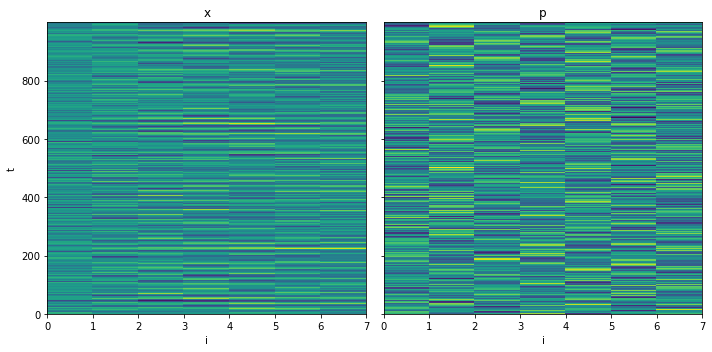

In [7]:
# presenting dynamics
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax[0].set_xlabel("i")
ax[1].set_xlabel("i")
ax[0].set_ylabel("t")

ax[0].pcolormesh(np.arange(d), ts, (sol.y.T)[:,:d])
ax[1].pcolormesh(np.arange(d), ts, (sol.y.T)[:,d:])

ax[0].set_title("x")
ax[1].set_title("p")

plt.tight_layout()
plt.show()